# Dependencies

In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchtext

/home/rvn/.envs/torch-2.2.0-cu-12.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Seeding to ensure reproducibility
seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# IMDB Dataset

Loading the dataset is very easy using the `datasets` package! The command below will download (if required in the *data/classification* directory) and load the IMDB dataset in a variable named `dataset`.

In [3]:
dataset = datasets.load_dataset("zapsdcn/imdb", cache_dir="../data/classification/")

The loaded `dataset` is already split into training, validation and testing sets. Looking at the outputs, we can see the number of examples (`num_rows`) in each split and three features named `id`, `text` and `label`.

In [4]:
train_dataset = dataset['train'] 
validation_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, validation_dataset, test_dataset

(Dataset({
     features: ['id', 'text', 'label'],
     num_rows: 20000
 }),
 Dataset({
     features: ['id', 'text', 'label'],
     num_rows: 5000
 }),
 Dataset({
     features: ['id', 'text', 'label'],
     num_rows: 25000
 }))

Looking at one such training example, we can see that 
- `id` contains information related to some index. Don't bother too much about this as this is not relevant for the application at hand.
- `text` is where we have the actual review!
- `label` denotes whether it's a good (if 1) or bad (if 0) review! 

In [5]:
train_dataset[-3]

{'id': 'train_10348',
 'text': 'This movie is very good. The screenplay is enchanting. But Meryl Streep is most impressive. Her performance is excellent. She brings me to go into the heart of her role.',
 'label': 1}

## Tokenization and Vocabulary Building

Computers only understand numbers. So we have to find a way to modify such that we can represent each word as a number. But first we have to split sentences into individual words. This is called Tokenization and is done using a tokenizer! 

I'm using a simple tokenizer provided by `torchtext`.

In [6]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

As expected, a tokenizer splits a text into words!

In [7]:
print(tokenizer(train_dataset[-3]["text"]))

['this', 'movie', 'is', 'very', 'good', '.', 'the', 'screenplay', 'is', 'enchanting', '.', 'but', 'meryl', 'streep', 'is', 'most', 'impressive', '.', 'her', 'performance', 'is', 'excellent', '.', 'she', 'brings', 'me', 'to', 'go', 'into', 'the', 'heart', 'of', 'her', 'role', '.']


Let's do this for all of the training, validation and testing dataset.

In [8]:
def tokenize(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [9]:
# Truncating the max length of a review because some of them ramble on for quite some time!
max_length = 512

train_dataset = train_dataset.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
validation_dataset = validation_dataset.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_dataset = test_dataset.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Let's build a volcabulary out of these tokens.

In [10]:
# Only selecting words at occur at least 5 times in the whole dataset
min_freq = 5

# Special tokens for unknown words and paddings (these will come in later)
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [11]:
print("Vocab Size: ", len(vocab))

Vocab Size:  25473


Making sure that words that are not in the vocabulary gets mapped to `"<unk>"` and assiging a token for padding as well (we'll cover padding later).

In [12]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

vocab.set_default_index(unk_index)

print(vocab["some_token_that_is_not_in_vocab"])

0


Now with this we can easily map any review to a sequence of numbers!

In [13]:
print(vocab.lookup_indices(train_dataset[-3]["tokens"]))

[14, 19, 10, 59, 57, 3, 2, 875, 10, 6752, 3, 22, 5124, 4287, 10, 97, 1168, 3, 47, 246, 10, 301, 3, 62, 934, 76, 8, 149, 90, 2, 534, 7, 47, 219, 3]


Let's do this in a more refined way for all of the datasets and store these number in the `id` feature!

In [14]:
def numericalize(example, vocab):
    id = vocab.lookup_indices(example["tokens"])
    return {"id": id}

In [15]:
train_dataset = train_dataset.map(numericalize, fn_kwargs={"vocab": vocab})
validation_dataset = validation_dataset.map(numericalize, fn_kwargs={"vocab": vocab})
test_dataset = test_dataset.map(numericalize, fn_kwargs={"vocab": vocab})

Converting to torch tensors to be loaded into Transformer!

In [16]:
train_dataset = train_dataset.with_format(type="torch", columns=["id", "label"])
validation_dataset = validation_dataset.with_format(type="torch", columns=["id", "label"])
test_dataset = test_dataset.with_format(type="torch", columns=["id", "label"])

## Data Loader

Let's now pad the sequences to make them of equal lengths and then load the dataset into pytorch data loaders.

In [17]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["id"] for i in batch]
        batch_ids = torch.nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"id": batch_ids, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [18]:
# Batch Size
batch_size = 512

train_data_loader = get_data_loader(train_dataset, batch_size, pad_index, shuffle=True)
validation_data_loader = get_data_loader(validation_dataset, batch_size, pad_index)
test_data_loader = get_data_loader(test_dataset, batch_size, pad_index)

You can think of pytorch data loaders as an iterable over which you can loop and get batches one by one!

# Transformers Neural Network

## Multi-Head Self Attention

In [19]:
class SelfAttention(torch.nn.Module):
    def __init__(self, emb, heads):
        super().__init__()
        assert emb % heads == 0
        self.emb, self.heads = emb, heads

        # Three emb x emb matrix multiplications to get queries, keys and values
        self.to_queries = torch.nn.Linear(emb, emb)
        self.to_keys = torch.nn.Linear(emb, emb)
        self.to_values = torch.nn.Linear(emb, emb)

        # One last Linear layer at the end with emb x emb matrix multiplication
        self.unify = torch.nn.Linear(emb, emb)

    def forward(self, x):
        b, t, emb = x.shape # Batch Size, Sequence Length, embedding dim
        h = self.heads

        # Computing queries, keys and values
        queries = self.to_queries(x)
        keys = self.to_keys(x)
        values = self.to_values(x)

        # Slicing out the heads
        queries = queries.view(b, t, h, emb//h)
        keys = keys.view(b, t, h, emb//h)
        values = values.view(b, t, h, emb//h)

        # Folding heads into batch dims (Remember head computations can run in parallel)
        queries = queries.transpose(1, 2).reshape(b*h, t, emb//h)
        keys = keys.transpose(1, 2).reshape(b*h, t, emb//h)
        values = values.transpose(1, 2).reshape(b*h, t, emb//h)

        # Here comes Self Attention...
        W = torch.bmm(queries, keys.transpose(1,2)) # Computing Weights
        W = W / (emb**(1/2)) # Scaling for stability
        W = F.softmax(W, dim=2) # Row-wise Softmax
        y = torch.bmm(W, values).view(b, h, t, emb//h) # Computing y
        y = y.transpose(1, 2).reshape(b, t, emb) # Concatenating heads

        # Final Linear NN Layer
        return self.unify(y), W

## Transformer Block

In [20]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, emb, heads):
        super().__init__()

        # Attention Block
        self.attention = SelfAttention(emb, heads)

        # Layer Normalizations
        self.norm1 = torch.nn.LayerNorm(emb)
        self.norm2 = torch.nn.LayerNorm(emb)

        # FCN
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(emb, 4*emb),
            torch.nn.ReLU(),
            torch.nn.Linear(4*emb, emb)
        )

    def forward(self, x):
        attented, W = self.attention(x)
        x = self.norm1(attented + x)
        ff = self.fcn(x)
        
        return self.norm2(ff + x), W

## Transformer Neural Network

In [21]:
class Transformer(torch.nn.Module):
    def __init__(self, emb, heads, max_seq_length, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size

        self.token_embedding = torch.nn.Embedding(embedding_dim=emb, num_embeddings=vocab_size)
        self.pos_embedding = torch.nn.Embedding(embedding_dim=emb, num_embeddings=max_seq_length)

        self.tblock = TransformerBlock(emb=emb, heads=heads)

        self.toprobs = torch.nn.Linear(emb, 2)

    def forward(self, x):
        tokens = self.token_embedding(x)
        b, t, e = tokens.shape
        
        positions = self.pos_embedding(torch.arange(t, device="cuda"))[None, :, :].expand(b, t, e)
        x = tokens + positions

        x, W = self.tblock(x)
        x = torch.mean(x, dim=1)
        x = self.toprobs(x)

        return F.log_softmax(x, dim=1), W

## Training

In [22]:
lr = 0.001
num_epochs = 20
heads = 4

model = Transformer(emb=32, heads=heads, max_seq_length=max_length, vocab_size=len(vocab)).to("cuda")

opt = torch.optim.Adam(lr=lr, params=model.parameters())

In [25]:
accs = []
for epoch in range(num_epochs):
    for batch in train_data_loader:
        opt.zero_grad()

        input = batch["id"].to("cuda")
        output = batch["label"].to("cuda")

        preds, _ = model(input)
        loss = F.nll_loss(preds, output)

        loss.backward()
        opt.step()

        with torch.no_grad():
            tot, cor= 0.0, 0.0
            for batch in validation_data_loader:
                input = batch["id"].to("cuda")
                output = batch["label"].to("cuda")

                if input.shape[1] > max_length:
                    input = input[:, :max_length]
                preds, _ = model(input)
                preds = preds.argmax(dim=1)

                tot += float(input.size(0))
                cor += float((output == preds).sum().item())

            acc = cor / tot
            accs.append(acc)

    print("Epoch:{}; Loss: {}; Validation Accuracy: {}".format(epoch, loss.item(), acc))

torch.save(model.state_dict(), "trained_models/clasify_{}heads.pt".format(heads))
np.save("trained_models/acc.npy", accs)

Epoch:0; Loss: 0.690449595451355; Accuracy: 0.5142
Epoch:1; Loss: 0.6767212748527527; Accuracy: 0.63248
Epoch:2; Loss: 0.6255638599395752; Accuracy: 0.672
Epoch:3; Loss: 0.5867947340011597; Accuracy: 0.71212
Epoch:4; Loss: 0.6983010172843933; Accuracy: 0.75448
Epoch:5; Loss: 0.37280407547950745; Accuracy: 0.77428
Epoch:6; Loss: 0.6024116277694702; Accuracy: 0.79
Epoch:7; Loss: 0.2825118899345398; Accuracy: 0.80928
Epoch:8; Loss: 0.2175906002521515; Accuracy: 0.81792
Epoch:9; Loss: 0.3413735628128052; Accuracy: 0.80576
Epoch:10; Loss: 0.20638501644134521; Accuracy: 0.82916
Epoch:11; Loss: 0.0660647600889206; Accuracy: 0.83424
Epoch:12; Loss: 0.23274169862270355; Accuracy: 0.8392
Epoch:13; Loss: 0.21374528110027313; Accuracy: 0.84268
Epoch:14; Loss: 0.30939772725105286; Accuracy: 0.84324
Epoch:15; Loss: 0.16323070228099823; Accuracy: 0.83836
Epoch:16; Loss: 0.12363114207983017; Accuracy: 0.83632
Epoch:17; Loss: 0.13967354595661163; Accuracy: 0.84076
Epoch:18; Loss: 0.115811787545681; Acc

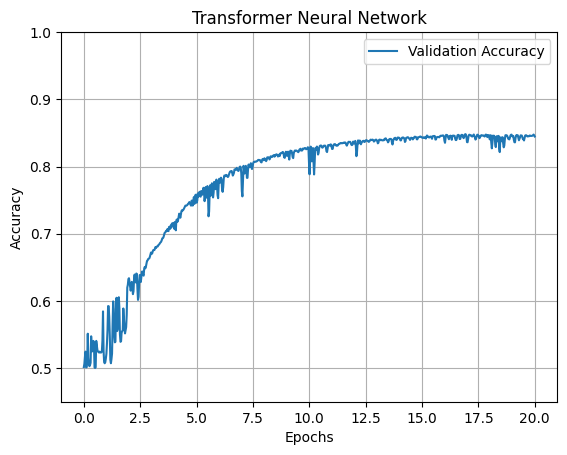

In [49]:
# Plot Validation Accuracy
accs = np.load("trained_models/acc.npy")
plt.style.use('default')
plt.plot(np.linspace(0, 20, len(accs)), accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.45, 1)
plt.grid()
plt.title("Transformer Neural Network")
plt.legend()
plt.show()

## Testing

In [24]:
# Load model with heads. Options: {1 or 4}
heads = 4 

# Loading Model
model.load_state_dict(torch.load("trained_models/clasify_{}heads.pt".format(heads)))

<All keys matched successfully>

In [25]:
acc = 0
with torch.no_grad():
    tot, cor= 0.0, 0.0
    for batch in validation_data_loader:
        input = batch["id"].to("cuda")
        output = batch["label"].to("cuda")

        if input.shape[1] > max_length:
            input = input[:, :max_length]
        preds, _ = model(input)
        preds = preds.argmax(dim=1)

        tot += float(input.size(0))
        cor += float((output == preds).sum().item())

    acc = cor / tot

print("Testing Accuracy: ", acc)

Testing Accuracy:  0.8306


## Visualizing Attention Weights

In [44]:
# Picking a random testing review
test_review = next(iter(test_data_loader))["id"][0]

# Printing 1st 10 words of the review
text = []
for num in list(test_review.numpy())[:10]:
    text.append(str(vocab.get_itos()[num]))
    print(vocab.get_itos()[num])

i
went
and
saw
this
movie
last
night
after
being


In [40]:
test_review.unsqueeze(0).shape

torch.Size([1, 512])

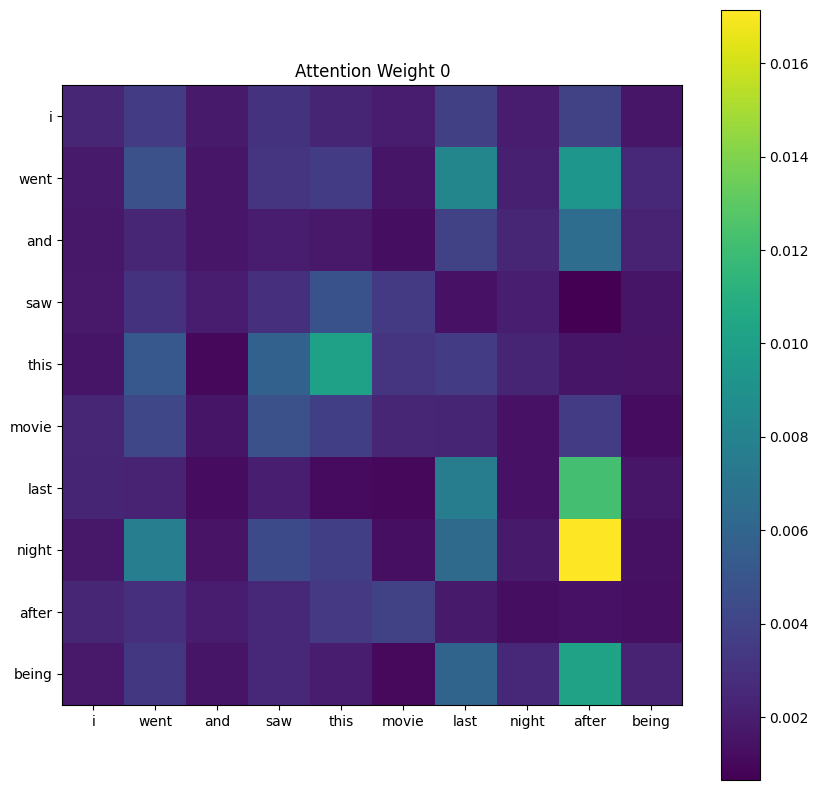

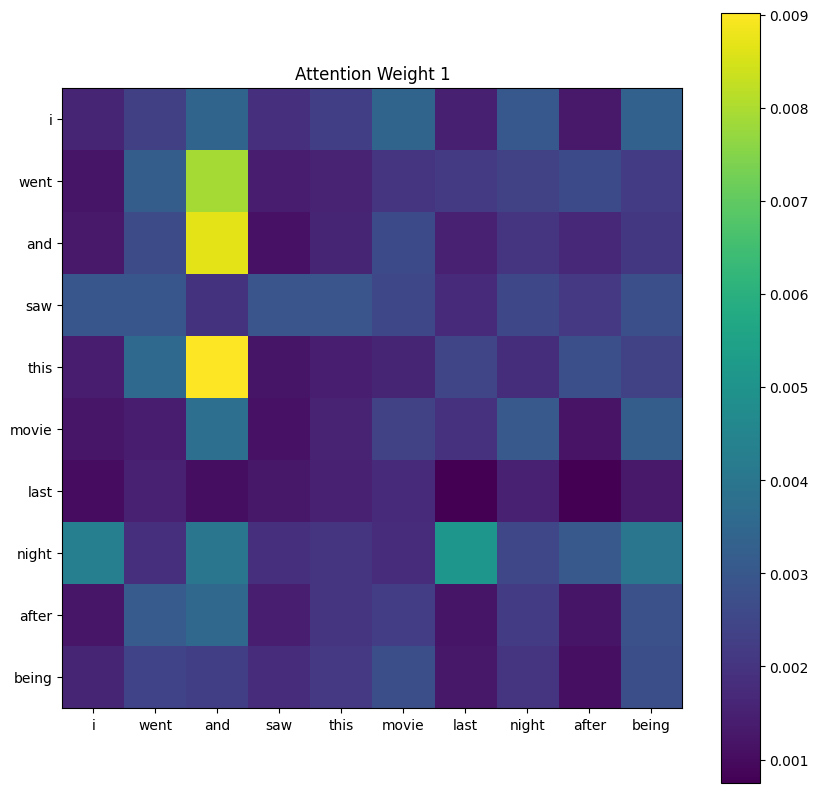

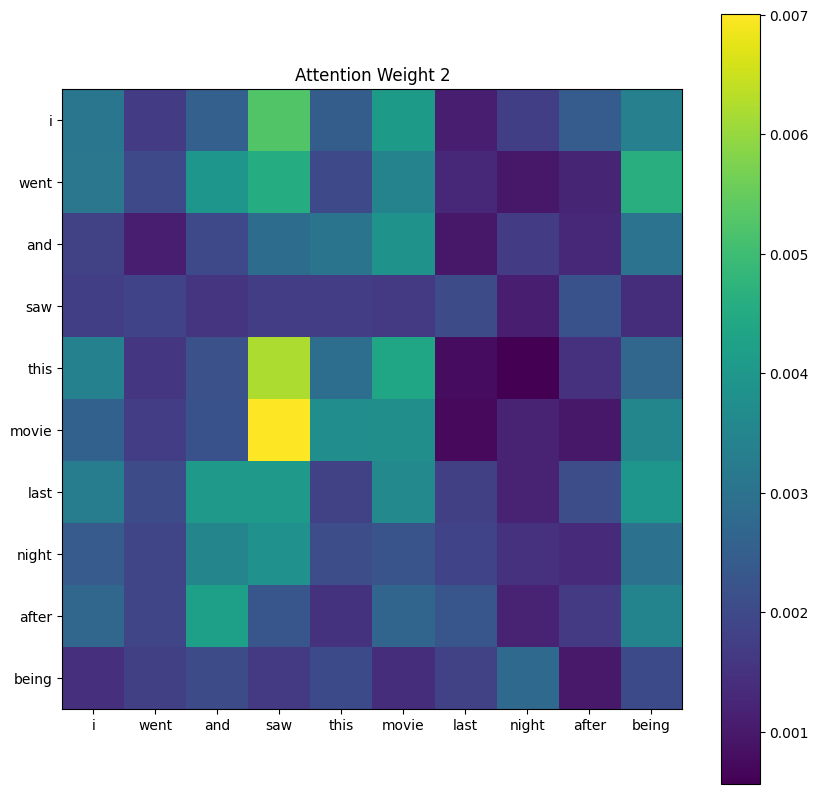

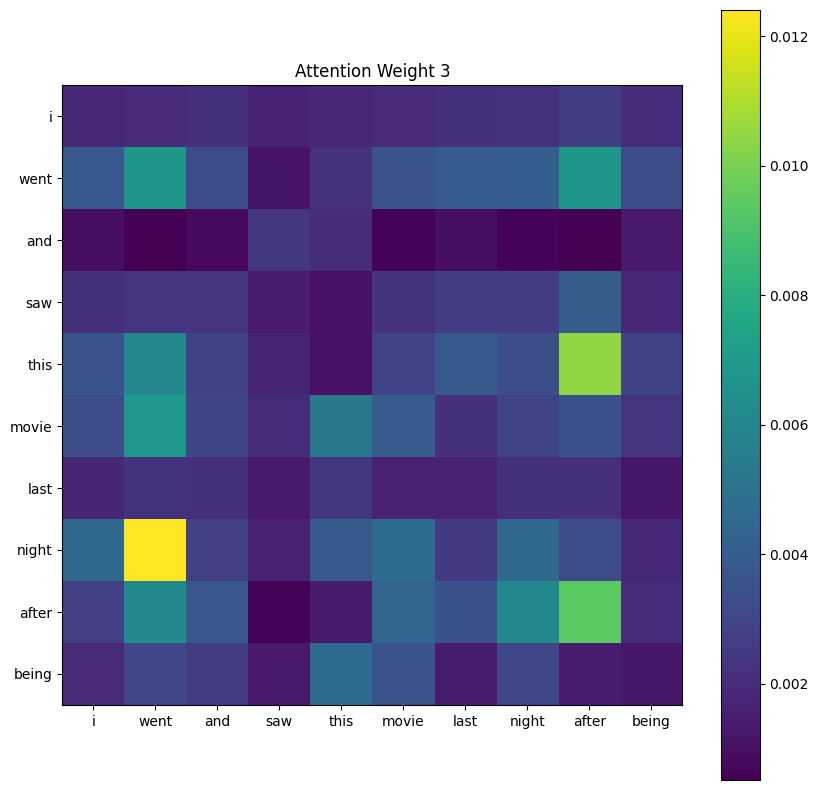

In [48]:
with torch.no_grad():
    _, attention = model(test_review.unsqueeze(0).to("cuda"))

    attention_weights = attention.cpu().numpy()
    
for (i, attention) in enumerate(attention_weights):
    plt.style.use('default')
    plt.figure(figsize=(10,10))
    plt.imshow(attention[:10, :10]) 
    plt.xticks(np.arange(0, 10), text[:10])
    plt.yticks(np.arange(0, 10), text[:10])
    plt.colorbar()
    plt.title("Attention Weight {}".format(i))
    plt.show()
